In [1]:
import numpy as np, prjlib, plottools as pl, healpy as hp, pickle, curvedsky, delens_tools, misctools, lens_tools
# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets
%matplotlib inline
from matplotlib.pyplot import *

In [2]:
def viewmaps(klms,nside=128,lmax=256,min=-0.1,max=0.1,M=1.):

    qlist = list(klms.keys())
    print(qlist)
    
    N = len(qlist)
    out = []
    for n in range(N):
        out.append(widgets.Output())

    tab = widgets.Tab(children = out)
    for n in range(N):
        tab.set_title(n,qlist[n])

    display(tab)

    fig, ax = {}, {}
    for qi, q in enumerate(qlist):
        kap = M * curvedsky.utils.hp_alm2map(12*nside**2,lmax,lmax,klms[q][:lmax+1,:lmax+1])

        with out[qi]:
            fig[q], ax[q] = subplots(figsize=[10,7])
            sca(ax[q])
            hp.mollview(kap,min=min,max=max,hold=True)
            show(fig[q])

In [3]:
p, f, r = prjlib.analysis_init(t='la',freq='coadd',snmin=1,snmax=50,rlmin=500,rlmax=3000,qlist=['TT','TE','EE','EB'])
P, __, __ = prjlib.analysis_init(t='la',freq='coadd',snmin=1,snmax=50,rlmin=500,rlmax=3000,qlist=['TT','TE','EE','EB'],exttag='_wdiag')
i = 1
nside = 128

In [4]:
W, M, wn = prjlib.window('la',p.nside)
M = hp.ud_grade(M,nside)
wn = prjlib.wfac('la')

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
fsky and normalization corrections: [0.5752538  0.14110665 0.04651988 0.01847941 0.008786  ]


In [5]:
ikalm = prjlib.load_input_plm(f.palm[i],p.dlmax,ktype='k')
ikwlm = prjlib.multiplywindow(W**2,p.npix,p.nside,p.dlmax,ikalm)

In [6]:
wlk = lens_tools.diag_wiener(p.quad.f,r.kk,p.dlmin,p.dlmax,qlist=p.quad.qlist)
rkalm = lens_tools.prep_klms(p.quad.f,i,p.dlmax,wn=wn,remove_mean=True,qlist=p.quad.qlist)
rkwlm = {}
for q in ['TT','TE','EE','EB']:
    rkwlm[q] = rkalm[q]*wlk[q][:,None]

In [7]:
wlK = lens_tools.diag_wiener(P.quad.f,r.kk,P.dlmin,P.dlmax,qlist=P.quad.qlist)
rKalm = lens_tools.prep_klms(P.quad.f,i,P.dlmax,wn=wn,remove_mean=True,qlist=P.quad.qlist)
rKwlm = {}
for q in ['TT','TE','EE','EB']:
    rKwlm[q] = rKalm[q]*wlK[q][:,None]

In [8]:
wkwlm = pickle.load(open(p.quad.f['TT'].walm[i],"rb"))[0]

In [9]:
klms = {}
klms['IN'] = ikalm
klms['INw'] = ikwlm/wn[2]
klms['TT'] = rkwlm['TT']/wn[2]
klms['TE'] = rkwlm['TE']/wn[1]
klms['EE'] = rkwlm['EE']/wn[0]
klms['EB'] = rkwlm['EB']/wn[0]
klms['TTw'] = wkwlm*100.
viewmaps(klms,M=M)

['IN', 'INw', 'TT', 'TE', 'EE', 'EB', 'TTw']


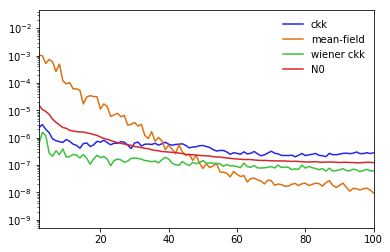

In [11]:
#cl0 = curvedsky.utils.alm2cl(2048,cklm)
lmax = 2048
qklm = pickle.load(open(p.quad.f['TT'].alm[i],"rb"))[0]
mklm = pickle.load(open(p.quad.f['TT'].mf,"rb"))[0]
cklm = qklm - mklm
cl0 = curvedsky.utils.alm2cl(lmax,cklm[:lmax+1,:lmax+1])/wn[4]
cl1 = curvedsky.utils.alm2cl(lmax,mklm[:lmax+1,:lmax+1])/wn[4]
cl2 = curvedsky.utils.alm2cl(lmax,wkwlm[:lmax+1,:lmax+1])*100**2
n0 = np.loadtxt(p.quad.f['TT'].n0bs,unpack=True)[1,:lmax+1]
xlim(2,100)
plot(cl0,label='ckk')
plot(cl1,label='mean-field')
plot(cl2,label='wiener ckk')
plot(n0,label='N0')
yscale('log')
legend()